In [138]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

In [139]:
# Load and prepare general dataset
df = pd.read_csv('/kaggle/input/startup-failures/Startup Failures.csv')
df = df.convert_dtypes()
df['Duration'] = df['Years of Operation'].str.extract(r'(\d+)').astype(int)
df['Start Year'] = df['Years of Operation'].str.extract(r'\((\d{4})-').fillna(0).astype(int)
df['End Year'] = df['Years of Operation'].str.extract(r'-(\d{4})\)').fillna(0).astype(int)

In [140]:
# Load sector-specific datasets
df_finance = pd.read_csv('/kaggle/input/startup-failures/Startup Failure (Finance and Insurance).csv')
df_food = pd.read_csv('/kaggle/input/startup-failures/Startup Failure (Food and services).csv')
df_health = pd.read_csv('/kaggle/input/startup-failures/Startup Failure (Health Care).csv')
df_manufactures = pd.read_csv('/kaggle/input/startup-failures/Startup Failure (Manufactures).csv')
df_retail = pd.read_csv('/kaggle/input/startup-failures/Startup Failure (Retail Trade).csv')
df_information = pd.read_csv('/kaggle/input/startup-failures/Startup Failures (Information Sector).csv')
sector_dfs = [df_finance, df_food, df_health, df_manufactures, df_retail, df_information]
for df_sector in sector_dfs:
    df_sector = df_sector.convert_dtypes()

In [141]:
df_finance.head()

,Name,Sector,Years of Operation,What They Did,How Much They Raised,Why They Failed,Takeaway,Giants,No Budget,Competition,Poor Market Fit,Acquisition Stagnation,Platform Dependency,Monetization Failure,Niche Limits,Execution Flaws,Trend Shifts,Toxicity/Trust Issues,Regulatory Pressure,Overhype
0,Avant,Finance and Insurance,2012-2023,Online personal loans,$655M,Lost to LendingClub and high defaults,Lending needs risk balance,1,1,1,0,0,0,0,0,0,0,0,0,0.0
1,Bitpass,Finance and Insurance,2002-2008,Micropayments platform,$2M,Lost to PayPal and low adoption,Micropayments need mass use,1,0,1,1,0,0,0,0,0,0,0,0,0.0
2,Cake Financial,Finance and Insurance,2006-2011,Portfolio tracking tool,$3M,Lost to Mint and sold to TradeKing,Finance tools need scale,1,0,1,0,1,0,0,0,0,0,0,0,0.0
3,Circle,Finance and Insurance,2013-2023,Crypto payments and stablecoin,$500M,Lost to Coinbase and market shifts,Crypto needs stability,1,0,1,0,0,0,0,0,0,1,0,0,0.0
4,Clarity Money,Finance and Insurance,2016-2022,Personal finance app,$11M,Lost to Mint/Acorns and sold to Goldman,Finance apps need edge,1,0,1,0,1,0,0,0,0,0,0,0,0.0


In [142]:
df_food.head()

,Name,Sector,Years of Operation,What They Did,How Much They Raised,Why They Failed,Takeaway,Giants,No Budget,Competition,Poor Market Fit,Acquisition Stagnation,High Operational Costs,Monetization Failure,Niche Limits,Execution Flaws,Trend Shifts
0,Cafe X,Accommodation and Food Services,6 (2015-2021),Robotic coffee kiosks,$15M,Closed 2021; low adoption; lost to Starbucks,Humans trump robots,1,0,1,1,0,1,0,0,0,0
1,Caviar,Accommodation and Food Services,8 (2012-2020),Premium food delivery,$90M,Sold 2020; couldn't scale; lost to DoorDash,Premium loses to scale,1,0,1,0,1,0,0,0,0,0
2,Chef'd,Accommodation and Food Services,5 (2014-2019),Meal kit delivery,$35M,Closed 2019; high costs; lost to Blue Apron,Costs cook meal kits,1,0,1,0,0,1,0,0,0,0
3,ChowNow,Accommodation and Food Services,12 (2011-2023),Restaurant ordering platform,$64M,Faded 2023; lost to DoorDash,Middlemen get squeezed,1,0,1,0,0,0,0,0,0,0
4,Clover,Accommodation and Food Services,8 (2012-2020),Plant-based fast food chain,$20M,Closed 2020; niche; lost to McDonald's,Niche eats need taste,1,0,1,0,0,1,0,1,0,0


In [143]:
# Functions
def clean_funding(x):
    if pd.isna(x) or 'Unknown' in str(x):
        return 0
    numeric_part = re.match(r'^\s*\$?(\d*\.?\d+)', str(x).replace('$', ''))
    if numeric_part:
        value = numeric_part.group(1)
        if 'M' in str(x).upper():
            return float(value) * 1e6
        elif 'K' in str(x).upper():
            return float(value) * 1e3
        else:
            return float(value)
    return 0

def extract_duration(x):
    if pd.isna(x):
        return 0
    # Try 'YYYY-YYYY' format first
    if '-' in x and '(' not in x:
        try:
            start_year, end_year = map(int, x.split('-'))
            return end_year - start_year
        except (ValueError, AttributeError):
            return 0
    # Then try 'X (YYYY-YYYY)' format
    match = re.search(r'(\d+)\s*\((\d{4})-(\d{4})\)', str(x))
    if match:
        return int(match.group(1))  # Use the pre-calculated duration
    # Fallback: Extract years and calculate
    years_match = re.search(r'(\d{4})-(\d{4})', str(x))
    if years_match:
        return int(years_match.group(2)) - int(years_match.group(1))
    return 0

In [144]:
# Prepare datasets
for df_sector in sector_dfs:
    df_sector['Duration'] = df_sector['Years of Operation'].apply(extract_duration)
    df_sector['Funding ($M)'] = df_sector['How Much They Raised'].apply(clean_funding) / 1e6

df['Funding ($M)'] = pd.NA
df['What They Did'] = pd.NA
df['How Much They Raised'] = pd.NA
df['Why They Failed'] = pd.NA
df['Takeaway'] = pd.NA

common_columns = ['Name', 'Sector', 'Years of Operation', 'Duration', 
                  'What They Did', 'How Much They Raised', 'Funding ($M)', 
                  'Why They Failed', 'Takeaway']

failure_reasons = set()
for df_sector in sector_dfs:
    failure_reasons.update([col for col in df_sector.columns if col not in common_columns])
failure_reasons = list(failure_reasons)

for reason in failure_reasons:
    if reason not in df.columns:
        df[reason] = 0

In [145]:
# Merge
all_dfs = [df] + sector_dfs
merged_df = pd.concat(all_dfs, axis=0, ignore_index=True, join='outer')
merged_df = merged_df.convert_dtypes()

<ipython-input-145-0e64435bec40>:3: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  merged_df = pd.concat(all_dfs, axis=0, ignore_index=True, join='outer')


In [146]:
# Fill missing values
filled_df = merged_df.copy()
filled_df['Funding ($M)'] = filled_df['Funding ($M)'].fillna(0)
filled_df['How Much They Raised'] = filled_df['How Much They Raised'].fillna('Unknown')
filled_df['What They Did'] = filled_df['What They Did'].fillna('Not Available')
filled_df['Why They Failed'] = filled_df['Why They Failed'].fillna('Not Available')
filled_df['Takeaway'] = filled_df['Takeaway'].fillna('Not Available')
filled_df['Start Year'] = filled_df['Start Year'].fillna(0).astype(int)
filled_df['End Year'] = filled_df['End Year'].fillna(0).astype(int)

for col in failure_reasons:
    filled_df[col] = filled_df[col].fillna(0).astype(int)

In [147]:
# Verify
print("Merged Info:", merged_df.info())
print("Filled Info:", filled_df.info())
print("Missing Values:", filled_df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1224 entries, 0 to 1223
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Name                    1224 non-null   string 
 1   Sector                  1224 non-null   string 
 2   Years of Operation      1224 non-null   string 
 3   Duration                1224 non-null   Int64  
 4   Start Year              815 non-null    Int64  
 5   End Year                815 non-null    Int64  
 6   Funding ($M)            409 non-null    Float64
 7   What They Did           409 non-null    string 
 8   How Much They Raised    409 non-null    string 
 9   Why They Failed         409 non-null    string 
 10  Takeaway                409 non-null    string 
 11  Regulatory Pressure     1198 non-null   Int64  
 12  Execution Flaws         1224 non-null   Int64  
 13  Platform Dependency     1198 non-null   Int64  
 14  Toxicity/Trust Issues   1198 non-null   

In [148]:
filled_df.head()

,Name,Sector,Years of Operation,Duration,Start Year,End Year,Funding ($M),What They Did,How Much They Raised,Why They Failed,...,High Operational Costs,Overhype,Competition,Poor Market Fit,No Budget,Acquisition Stagnation,Trend Shifts,Monetization Failure,Giants,Niche Limits
0,99dresses,Retail Trade,3 (2010-2013),3,2010,2013,0.0,Not Available,Unknown,Not Available,...,0,0,0,0,0,0,0,0,0,0
1,Ahalife,Retail Trade,7 (2010-2017),7,2010,2017,0.0,Not Available,Unknown,Not Available,...,0,0,0,0,0,0,0,0,0,0
2,Airy Labs,Information,2 (2010-2012),2,2010,2012,0.0,Not Available,Unknown,Not Available,...,0,0,0,0,0,0,0,0,0,0
3,AllRomance,Retail Trade,10 (2006-2016),10,2006,2016,0.0,Not Available,Unknown,Not Available,...,0,0,0,0,0,0,0,0,0,0
4,Ampush,Professional Scientific and Technical Services,13 (2010-2023),13,2010,2023,0.0,Not Available,Unknown,Not Available,...,0,0,0,0,0,0,0,0,0,0


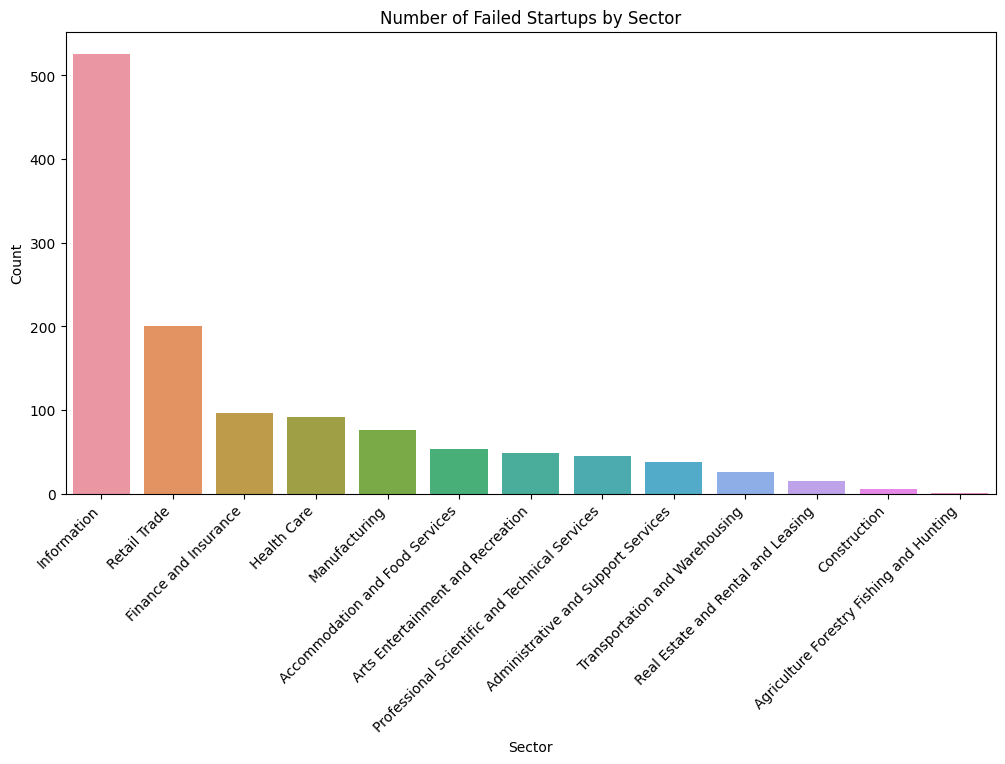

Top 5 Sectors by Failure Count:
 Sector
Information              526
Retail Trade             200
Finance and Insurance     97
Health Care               92
Manufacturing             76
Name: count, dtype: Int64


In [149]:
# Sector counts
sector_counts = filled_df['Sector'].value_counts()

# Bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x=sector_counts.index, y=sector_counts.values)
plt.xticks(rotation=45, ha='right')
plt.title('Number of Failed Startups by Sector')
plt.xlabel('Sector')
plt.ylabel('Count')
plt.show()

print("Top 5 Sectors by Failure Count:\n", sector_counts.head())

Duration Statistics:
 count      1224.0
mean     7.588235
std      3.386336
min           0.0
25%           5.0
50%           7.0
75%          10.0
max          18.0
Name: Duration, dtype: Float64


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


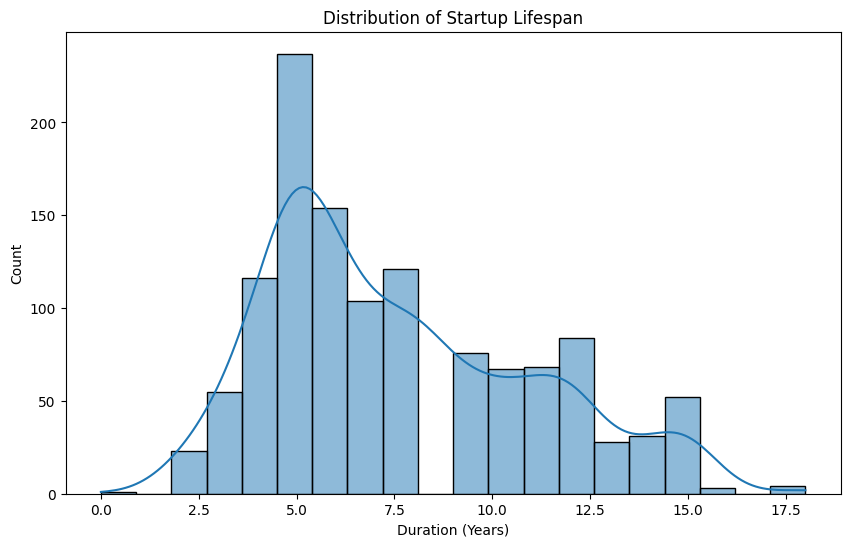

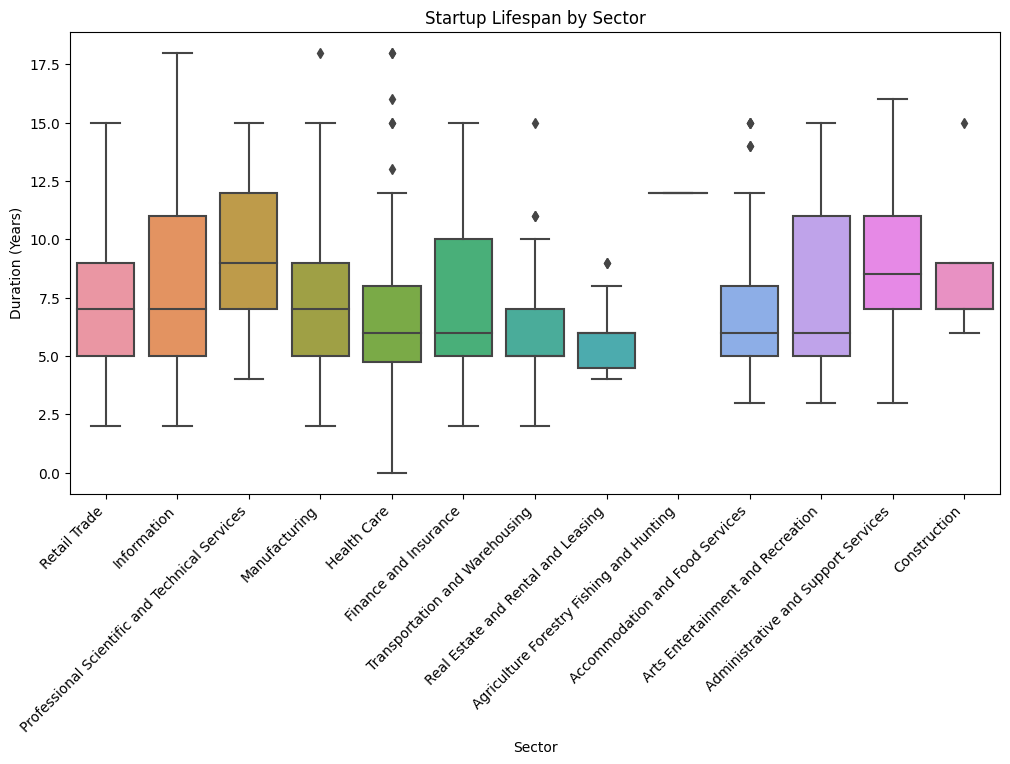

In [150]:
# Summary statistics
print("Duration Statistics:\n", filled_df['Duration'].describe())

# Histogram of Duration
plt.figure(figsize=(10, 6))
sns.histplot(filled_df['Duration'], bins=20, kde=True)
plt.title('Distribution of Startup Lifespan')
plt.xlabel('Duration (Years)')
plt.ylabel('Count')
plt.show()

# Boxplot by Sector
plt.figure(figsize=(12, 6))
sns.boxplot(x='Sector', y='Duration', data=filled_df)
plt.xticks(rotation=45, ha='right')
plt.title('Startup Lifespan by Sector')
plt.xlabel('Sector')
plt.ylabel('Duration (Years)')
plt.show()

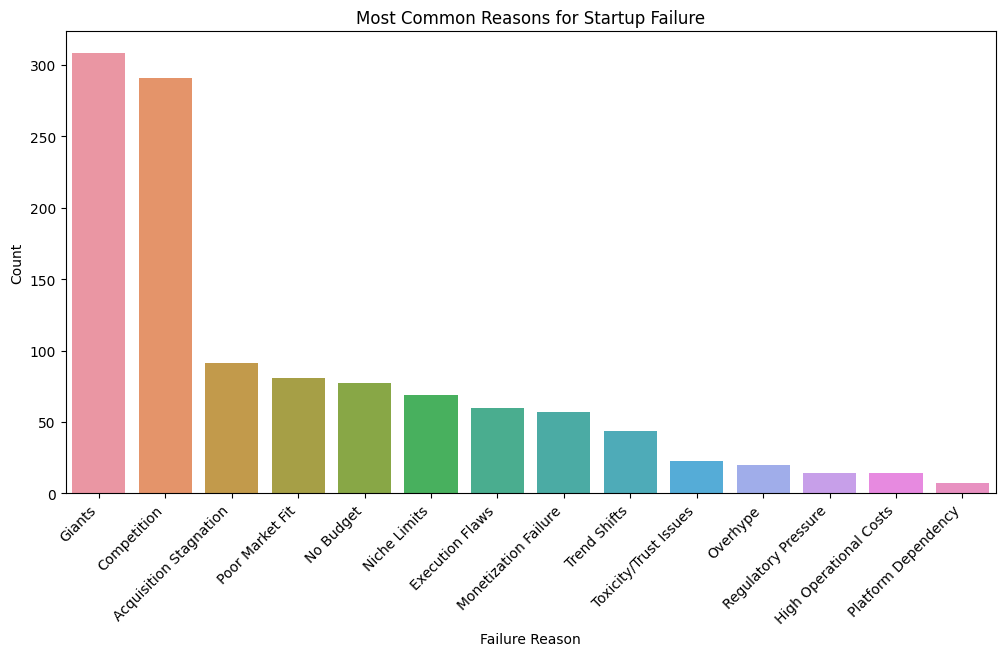

Top Failure Reasons:
 Giants                    308
Competition               291
Acquisition Stagnation     91
Poor Market Fit            81
No Budget                  77
dtype: int64


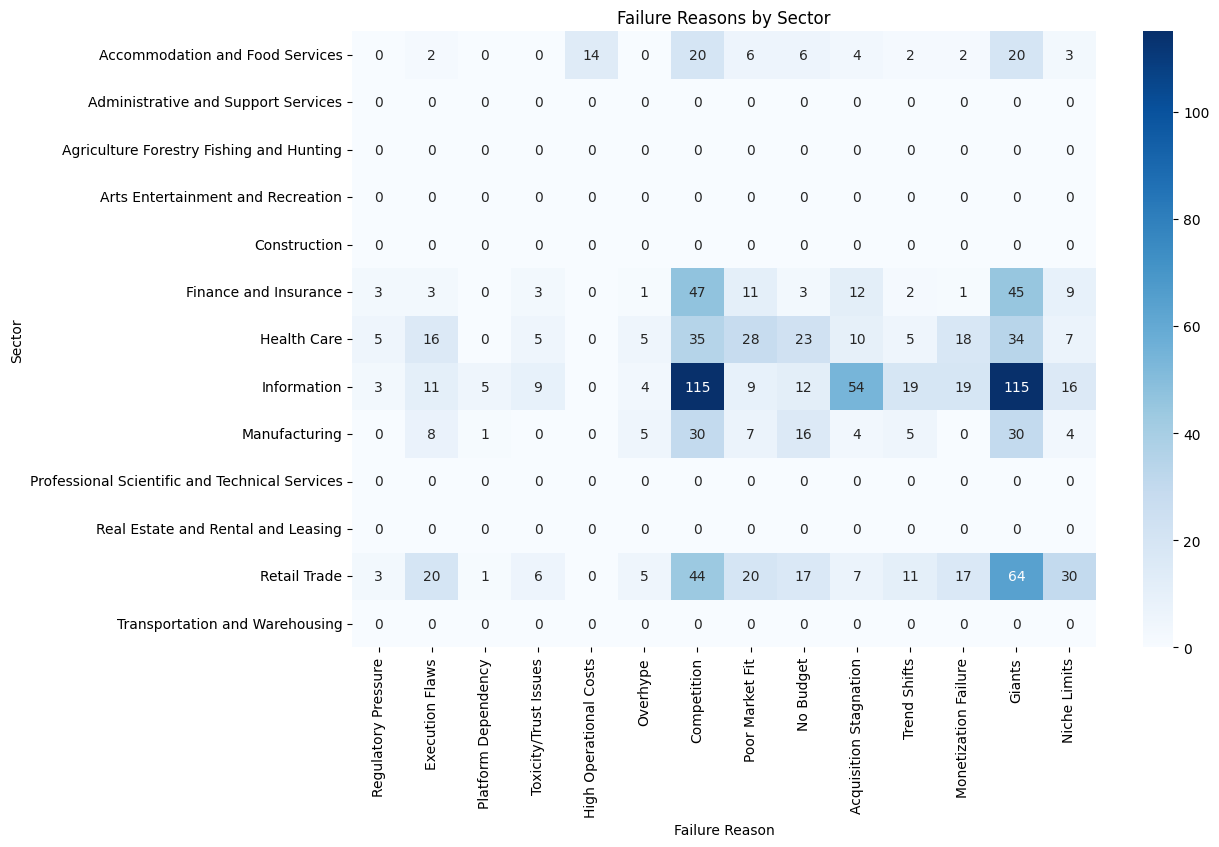

In [151]:
# Sum failure reasons
failure_reasons = [col for col in filled_df.columns if col not in 
                   ['Name', 'Sector', 'Years of Operation', 'Duration', 'Start Year', 'End Year',
                    'What They Did', 'How Much They Raised', 'Funding ($M)', 'Why They Failed', 'Takeaway']]
failure_counts = filled_df[failure_reasons].sum().sort_values(ascending=False)

# Bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x=failure_counts.index, y=failure_counts.values)
plt.xticks(rotation=45, ha='right')
plt.title('Most Common Reasons for Startup Failure')
plt.xlabel('Failure Reason')
plt.ylabel('Count')
plt.show()

print("Top Failure Reasons:\n", failure_counts.head())

# Heatmap by Sector
failure_by_sector = filled_df.groupby('Sector')[failure_reasons].sum()
plt.figure(figsize=(12, 8))
sns.heatmap(failure_by_sector, annot=True, cmap='Blues', fmt='d')
plt.title('Failure Reasons by Sector')
plt.xlabel('Failure Reason')
plt.ylabel('Sector')
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


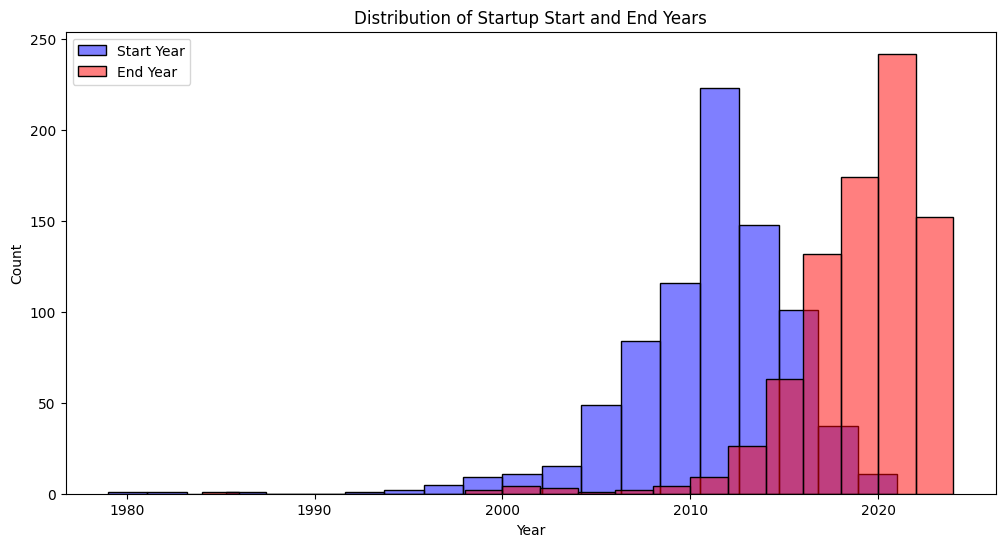

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


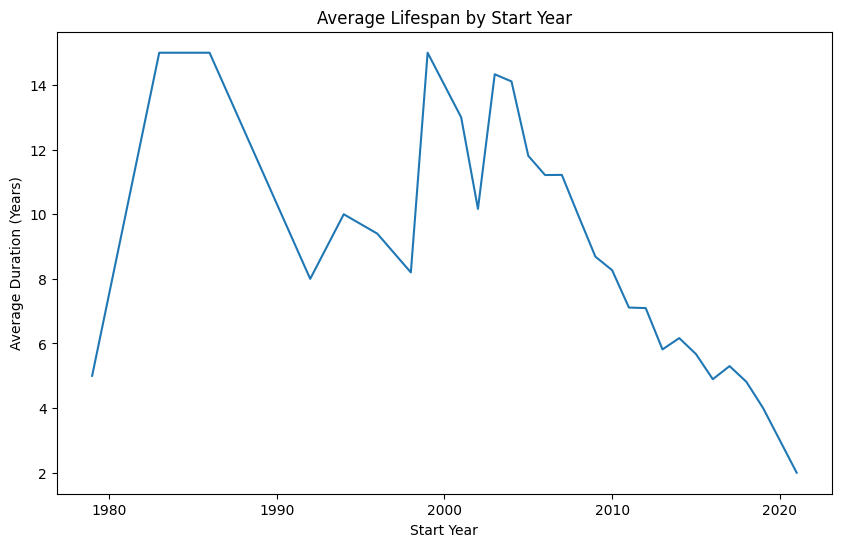

In [152]:
# Filter out imputed zeros for meaningful trends
non_zero_years = filled_df[(filled_df['Start Year'] > 0) & (filled_df['End Year'] > 0)]

# Histogram of Start and End Years
plt.figure(figsize=(12, 6))
sns.histplot(non_zero_years['Start Year'], bins=20, color='blue', label='Start Year', alpha=0.5)
sns.histplot(non_zero_years['End Year'], bins=20, color='red', label='End Year', alpha=0.5)
plt.legend()
plt.title('Distribution of Startup Start and End Years')
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()

# Average duration by Start Year
duration_by_start = non_zero_years.groupby('Start Year')['Duration'].mean()
plt.figure(figsize=(10, 6))
sns.lineplot(x=duration_by_start.index, y=duration_by_start.values)
plt.title('Average Lifespan by Start Year')
plt.xlabel('Start Year')
plt.ylabel('Average Duration (Years)')
plt.show()

# **Giants prediction** #

<ipython-input-153-82dffc1391c1>:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[11 11  7 ...  7  7  7]' has dtype incompatible with string, please explicitly cast to a compatible dtype first.
  X.loc[:, 'Sector'] = le.fit_transform(X['Sector'])


Epoch 1/100, Train Loss: 0.6524, Val Loss: 0.6036, Test Loss: 0.6002, Train Acc: 0.6724, Val Acc: 0.8836, Test Acc: 0.9018
Epoch 9/100, Train Loss: 0.1929, Val Loss: 0.2101, Test Loss: 0.1429, Train Acc: 0.9423, Val Acc: 0.9345, Test Acc: 0.9600
Epoch 17/100, Train Loss: 0.1603, Val Loss: 0.1970, Test Loss: 0.1274, Train Acc: 0.9438, Val Acc: 0.9382, Test Acc: 0.9673
Epoch 25/100, Train Loss: 0.1526, Val Loss: 0.1883, Test Loss: 0.1211, Train Acc: 0.9516, Val Acc: 0.9382, Test Acc: 0.9636
Epoch 33/100, Train Loss: 0.1476, Val Loss: 0.1807, Test Loss: 0.1161, Train Acc: 0.9548, Val Acc: 0.9418, Test Acc: 0.9636
Epoch 41/100, Train Loss: 0.1441, Val Loss: 0.1781, Test Loss: 0.1121, Train Acc: 0.9563, Val Acc: 0.9418, Test Acc: 0.9636
Epoch 49/100, Train Loss: 0.1380, Val Loss: 0.1732, Test Loss: 0.1113, Train Acc: 0.9571, Val Acc: 0.9418, Test Acc: 0.9600
Epoch 57/100, Train Loss: 0.1246, Val Loss: 0.1694, Test Loss: 0.1100, Train Acc: 0.9626, Val Acc: 0.9491, Test Acc: 0.9600
Epoch 65/1

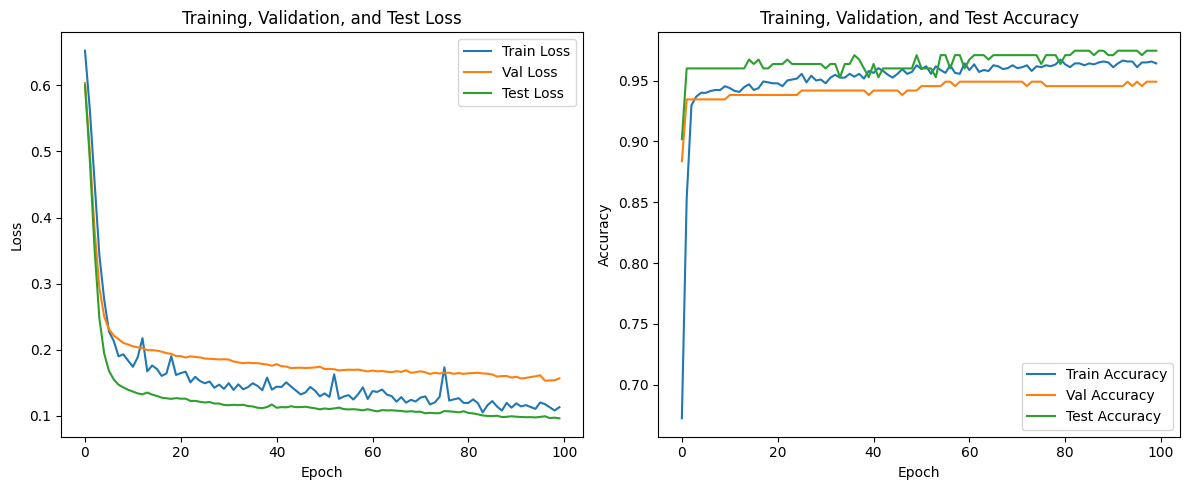

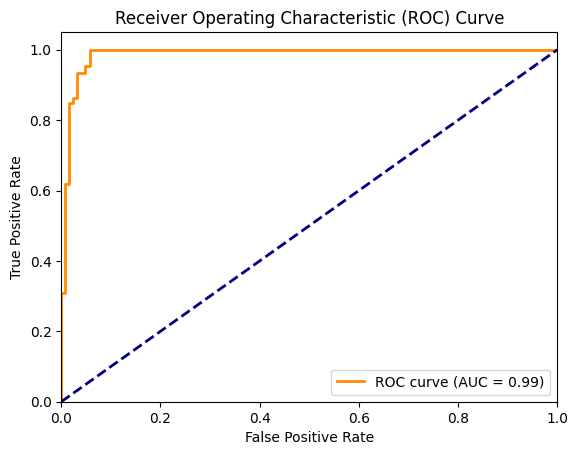

Final Metrics on Test Set:
Accuracy: 0.9745
Sensitivity (Recall): 1.0000
Confusion Matrix:
[[116   7]
 [  0 152]]
ROC AUC: 0.9875
Model saved as 'giants_classifier.pth'


In [153]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, recall_score

# Data Preparation (same as before)
features = ['Sector', 'Duration', 'Start Year', 'End Year', 'Funding ($M)', 
            'No Budget', 'Competition', 'Poor Market Fit', 'Acquisition Stagnation', 
            'Platform Dependency', 'Monetization Failure', 'Niche Limits', 
            'Execution Flaws', 'Trend Shifts', 'Toxicity/Trust Issues', 
            'Regulatory Pressure', 'Overhype', 'High Operational Costs']
target = 'Giants'

X = filled_df[features]
y = filled_df[target]

le = LabelEncoder()
X.loc[:, 'Sector'] = le.fit_transform(X['Sector'])

X = X.values.astype(np.float32)
y = y.values.astype(np.int64)

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

X_temp, X_test, y_temp, y_test = train_test_split(X_resampled, y_resampled, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Dataset and DataLoader
class StartupDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = StartupDataset(X_train, y_train)
val_dataset = StartupDataset(X_val, y_val)
test_dataset = StartupDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# ANN Model
class ANN(nn.Module):
    def __init__(self, input_size):
        super(ANN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 2)
        )
    
    def forward(self, x):
        return self.layers(x)

input_size = X_train.shape[1]
model = ANN(input_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0003)

# Training with metrics tracking
def train_model(model, train_loader, val_loader, test_loader, criterion, optimizer, epochs=100):
    train_losses, val_losses, test_losses = [], [], []
    train_accuracies, val_accuracies, test_accuracies = [], [], []
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_total += y_batch.size(0)
            train_correct += (predicted == y_batch).sum().item()
        
        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(train_correct / train_total)
        
        # Validation
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += y_batch.size(0)
                val_correct += (predicted == y_batch).sum().item()
        
        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(val_correct / val_total)
        
        # Test
        test_loss = 0
        test_correct = 0
        test_total = 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                test_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                test_total += y_batch.size(0)
                test_correct += (predicted == y_batch).sum().item()
        
        test_losses.append(test_loss / len(test_loader))
        test_accuracies.append(test_correct / test_total)
        if (epoch % 8 == 0):
            print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, '
                  f'Val Loss: {val_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, '
                  f'Train Acc: {train_accuracies[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}, '
                  f'Test Acc: {test_accuracies[-1]:.4f}')
    
    return train_losses, val_losses, test_losses, train_accuracies, val_accuracies, test_accuracies

# Train and get metrics
train_losses, val_losses, test_losses, train_accuracies, val_accuracies, test_accuracies = train_model(
    model, train_loader, val_loader, test_loader, criterion, optimizer, epochs=100
)

# Plotting
plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Training, Validation, and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Training, Validation, and Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Final Evaluation
model.eval()
y_true = []
y_scores = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        probabilities = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()  # Probability of class 1
        y_scores.extend(probabilities)
        y_true.extend(y_batch.cpu().numpy())

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Final Metrics
y_pred = [1 if score >= 0.5 else 0 for score in y_scores]
accuracy = accuracy_score(y_true, y_pred)
sensitivity = recall_score(y_true, y_pred)  # Sensitivity = Recall for positive class
conf_matrix = confusion_matrix(y_true, y_pred)

print(f"Final Metrics on Test Set:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"ROC AUC: {roc_auc:.4f}")

# Save the model
torch.save(model.state_dict(), 'giants_classifier.pth')
print("Model saved as 'giants_classifier.pth'")

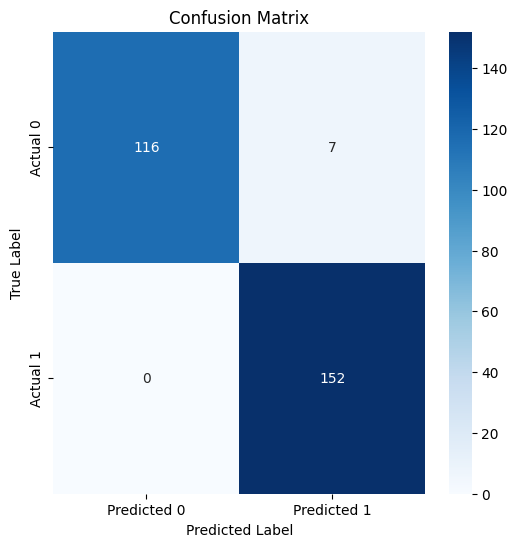

Final Metrics on Test Set:
Accuracy: 0.9745
Sensitivity (Recall): 1.0000
ROC AUC: 0.9875


In [155]:
# Confusion Matrix Plot
y_pred = [1 if score >= 0.5 else 0 for score in y_scores]
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Final Metrics
accuracy = accuracy_score(y_true, y_pred)
sensitivity = recall_score(y_true, y_pred)
print(f"Final Metrics on Test Set:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

# Lifespan regression # 

Epoch 1/1000, Train Loss: 84.1302, Val Loss: 78.3200, Test Loss: 79.8771, Train RMSE: 9.1658, Val RMSE: 8.8751, Test RMSE: 8.9518
Epoch 81/1000, Train Loss: 44.5612, Val Loss: 42.0694, Test Loss: 42.0174, Train RMSE: 6.6836, Val RMSE: 6.5031, Test RMSE: 6.5083
Epoch 161/1000, Train Loss: 17.8575, Val Loss: 17.2130, Test Loss: 15.6913, Train RMSE: 4.2248, Val RMSE: 4.1512, Test RMSE: 3.9917
Epoch 241/1000, Train Loss: 15.8427, Val Loss: 14.1714, Test Loss: 13.2995, Train RMSE: 3.9881, Val RMSE: 3.7533, Test RMSE: 3.6726
Epoch 321/1000, Train Loss: 15.4634, Val Loss: 12.9179, Test Loss: 12.4773, Train RMSE: 3.9308, Val RMSE: 3.5781, Test RMSE: 3.5572
Epoch 401/1000, Train Loss: 13.9863, Val Loss: 12.3281, Test Loss: 12.0984, Train RMSE: 3.7301, Val RMSE: 3.4940, Test RMSE: 3.5031
Epoch 481/1000, Train Loss: 14.6045, Val Loss: 11.9938, Test Loss: 11.9075, Train RMSE: 3.8276, Val RMSE: 3.4458, Test RMSE: 3.4758
Epoch 561/1000, Train Loss: 14.7233, Val Loss: 11.7867, Test Loss: 11.8317, Tra

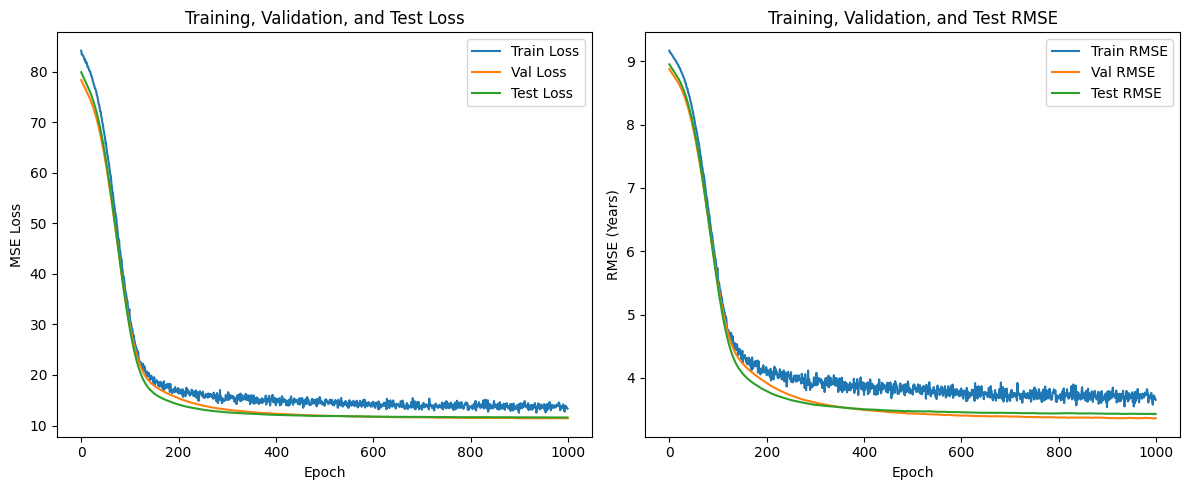

Train Final Metrics:
Loss (MSE): 10.4733
RMSE: 3.2318

Val Final Metrics:
Loss (MSE): 11.4393
RMSE: 3.3633

Test Final Metrics:
Loss (MSE): 11.5907
RMSE: 3.4306

Model saved as 'lifespan_predictor.pth'


In [120]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# Data Preparation
features = ['Funding ($M)', 'Start Year', 'End Year', 'No Budget', 'Competition', 
            'Poor Market Fit', 'Acquisition Stagnation', 'Platform Dependency', 
            'Monetization Failure', 'Niche Limits', 'Execution Flaws', 
            'Trend Shifts', 'Toxicity/Trust Issues', 'Regulatory Pressure', 
            'Overhype', 'High Operational Costs']
target = 'Duration'

X = filled_df[features].values.astype(np.float32)
y = filled_df[target].values.astype(np.float32)

# Split dataset: 70% train, 15% val, 15% test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, random_state=42)

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Custom Dataset class
class StartupDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).view(-1, 1)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create DataLoaders
train_dataset = StartupDataset(X_train, y_train)
val_dataset = StartupDataset(X_val, y_val)
test_dataset = StartupDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Attention Layer
class Attention(nn.Module):
    def __init__(self, feature_dim):
        super(Attention, self).__init__()
        self.attention = nn.Linear(feature_dim, 1)
    
    def forward(self, x):
        attention_weights = torch.softmax(self.attention(x), dim=1)
        weighted_features = x * attention_weights
        return weighted_features.sum(dim=1, keepdim=True)

# Neural Network with Attention
class AttentionNet(nn.Module):
    def __init__(self, input_size):
        super(AttentionNet, self).__init__()
        self.attention = Attention(input_size)
        self.fc1 = nn.Linear(input_size, 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
    
    def forward(self, x):
        attended = self.attention(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x + attended

# Initialize model, loss, and optimizer
input_size = X_train.shape[1]
model = AttentionNet(input_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00003)

# Training function with RMSE
def train_model(model, train_loader, val_loader, test_loader, criterion, optimizer, epochs=50):
    train_losses, val_losses, test_losses = [], [], []
    train_rmses, val_rmses, test_rmses = [], [], []
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        train_preds = []
        train_true = []
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_preds.append(outputs.detach().cpu().numpy())  # Collect as numpy arrays
            train_true.append(y_batch.cpu().numpy())
        
        train_preds = np.concatenate(train_preds).flatten()
        train_true = np.concatenate(train_true).flatten()
        train_losses.append(train_loss / len(train_loader))
        train_rmse = np.sqrt(np.mean((train_true - train_preds) ** 2))
        train_rmses.append(train_rmse)
        
        # Validation
        model.eval()
        val_loss = 0
        val_preds = []
        val_true = []
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()
                val_preds.append(outputs.cpu().numpy())
                val_true.append(y_batch.cpu().numpy())
        
        val_preds = np.concatenate(val_preds).flatten()
        val_true = np.concatenate(val_true).flatten()
        val_losses.append(val_loss / len(val_loader))
        val_rmse = np.sqrt(np.mean((val_true - val_preds) ** 2))
        val_rmses.append(val_rmse)
        
        # Test
        test_loss = 0
        test_preds = []
        test_true = []
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                test_loss += loss.item()
                test_preds.append(outputs.cpu().numpy())
                test_true.append(y_batch.cpu().numpy())
        
        test_preds = np.concatenate(test_preds).flatten()
        test_true = np.concatenate(test_true).flatten()
        test_losses.append(test_loss / len(test_loader))
        test_rmse = np.sqrt(np.mean((test_true - test_preds) ** 2))
        test_rmses.append(test_rmse)

        if (epoch % 80 == 0):
            print(f'Epoch {epoch+1}/{epochs}, '
                  f'Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, '
                  f'Train RMSE: {train_rmses[-1]:.4f}, Val RMSE: {val_rmses[-1]:.4f}, Test RMSE: {test_rmses[-1]:.4f}')
        
    return train_losses, val_losses, test_losses, train_rmses, val_rmses, test_rmses

# Train the model
train_losses, val_losses, test_losses, train_rmses, val_rmses, test_rmses = train_model(
    model, train_loader, val_loader, test_loader, criterion, optimizer, epochs=1000
)

# Plotting
plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Training, Validation, and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()

# RMSE Plot
plt.subplot(1, 2, 2)
plt.plot(train_rmses, label='Train RMSE')
plt.plot(val_rmses, label='Val RMSE')
plt.plot(test_rmses, label='Test RMSE')
plt.title('Training, Validation, and Test RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE (Years)')
plt.legend()

plt.tight_layout()
plt.show()

# Final Evaluation
model.eval()
sets = {'Train': train_loader, 'Val': val_loader, 'Test': test_loader}
for set_name, loader in sets.items():
    set_loss = 0
    y_true, y_pred = [], []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            set_loss += loss.item()
            y_true.append(y_batch.cpu().numpy())
            y_pred.append(outputs.cpu().numpy())
    
    y_true = np.concatenate(y_true).flatten()
    y_pred = np.concatenate(y_pred).flatten()
    set_rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    print(f"{set_name} Final Metrics:")
    print(f"Loss (MSE): {set_loss / len(loader):.4f}")
    print(f"RMSE: {set_rmse:.4f}\n")

# Save the model
torch.save(model.state_dict(), 'lifespan_predictor.pth')
print("Model saved as 'lifespan_predictor.pth'")

In [121]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn

# Define the Attention Layer
class Attention(nn.Module):
    def __init__(self, feature_dim):
        super(Attention, self).__init__()
        self.attention = nn.Linear(feature_dim, 1)
    
    def forward(self, x):
        attention_weights = torch.softmax(self.attention(x), dim=1)
        weighted_features = x * attention_weights
        return weighted_features.sum(dim=1, keepdim=True)

# Define the AttentionNet model
class AttentionNet(nn.Module):
    def __init__(self, input_size):
        super(AttentionNet, self).__init__()
        self.attention = Attention(input_size)
        self.fc1 = nn.Linear(input_size, 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
    
    def forward(self, x):
        attended = self.attention(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x + attended

# Features expected by the model
features = ['Funding ($M)', 'Start Year', 'End Year', 'No Budget', 'Competition', 
            'Poor Market Fit', 'Acquisition Stagnation', 'Platform Dependency', 
            'Monetization Failure', 'Niche Limits', 'Execution Flaws', 
            'Trend Shifts', 'Toxicity/Trust Issues', 'Regulatory Pressure', 
            'Overhype', 'High Operational Costs']

# Your sample data as a DataFrame
sample_data = pd.DataFrame({
    'Name': ['Avant', 'Bitpass', 'Cake Financial', 'Circle', 'Clarity Money'],
    'Funding ($M)': [655, 2, 3, 500, 11],
    'Start Year': [2012, 2002, 2006, 2013, 2016],
    'End Year': [2023, 2008, 2011, 2023, 2022],
    'No Budget': [1, 0, 0, 0, 0],
    'Competition': [1, 1, 1, 1, 1],
    'Poor Market Fit': [0, 1, 0, 0, 0],
    'Acquisition Stagnation': [0, 0, 1, 0, 1],
    'Platform Dependency': [0, 0, 0, 0, 0],
    'Monetization Failure': [0, 0, 0, 0, 0],
    'Niche Limits': [0, 0, 0, 0, 0],
    'Execution Flaws': [0, 0, 0, 0, 0],
    'Trend Shifts': [0, 0, 0, 1, 0],
    'Toxicity/Trust Issues': [0, 0, 0, 0, 0],
    'Regulatory Pressure': [0, 0, 0, 0, 0],
    'Overhype': [0.0, 0.0, 0.0, 0.0, 0.0],
    'High Operational Costs': [0, 0, 0, 0, 0]  # Added as 0 since not in sample
})

# Extract features and names
X_sample = sample_data[features].values.astype(np.float32)
sample_names = sample_data['Name'].values

# Load the trained model
input_size = len(features)  # 16 features
model = AttentionNet(input_size)
model.load_state_dict(torch.load('/kaggle/working/lifespan_predictor.pth'))
model.eval()
print("Model loaded successfully from '/kaggle/working/lifespan_predictor.pth'")

# Prepare the scaler (fit on filled_df for consistency; ideally load from training)
scaler = StandardScaler()
scaler.fit(filled_df[features].values.astype(np.float32))  # Replace with saved scaler if available

# Normalize the sample data
X_sample_normalized = scaler.transform(X_sample)

# Convert to PyTorch tensor
input_tensor = torch.tensor(X_sample_normalized, dtype=torch.float32)

# Perform inference
with torch.no_grad():
    predictions = model(input_tensor).cpu().numpy().flatten()

# Display results with true lifespan for comparison
true_lifespan = sample_data['End Year'] - sample_data['Start Year']  # From sample data
print("\nInference Results:")
for name, pred, true in zip(sample_names, predictions, true_lifespan):
    print(f"Startup: {name}, Predicted Lifespan: {pred:.2f} years, True Lifespan: {true:.2f} years")

Model loaded successfully from '/kaggle/working/lifespan_predictor.pth'

Inference Results:
Startup: Avant, Predicted Lifespan: 10.26 years, True Lifespan: 11.00 years
Startup: Bitpass, Predicted Lifespan: 7.63 years, True Lifespan: 6.00 years
Startup: Cake Financial, Predicted Lifespan: 9.40 years, True Lifespan: 5.00 years
Startup: Circle, Predicted Lifespan: 9.68 years, True Lifespan: 10.00 years
Startup: Clarity Money, Predicted Lifespan: 9.44 years, True Lifespan: 6.00 years


<ipython-input-121-fcf1f8088f24>:75: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/kaggle/working/lifespan_predictor.pth'))
